In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import json
import os
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cairosvg
from PIL import Image

2025-01-17 20:09:19.219628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737144559.240962   45074 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737144559.246754   45074 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 20:09:19.267179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open("../configs/config.json", "r") as file:
    config = json.load(file)

# Виведення конфігурації
print(config)

{'data': {'raw_path': '../data/raw/svg', 'png_path': '../data/precessed/png_images', 'precessed_path': '../data/precessed/tfrec', 'class_names': ['airplane', 'alarm clock', 'angel', 'ant', 'apple', 'arm', 'armchair', 'ashtray', 'axe', 'backpack', 'banana', 'barn', 'baseball bat', 'basket', 'bathtub', 'bear (animal)', 'bed', 'bee', 'beer-mug', 'bell', 'bench', 'bicycle', 'binoculars', 'blimp', 'book', 'bookshelf', 'boomerang', 'bottle opener', 'bowl', 'brain', 'bread', 'bridge', 'bulldozer', 'bus', 'bush', 'butterfly', 'cabinet', 'cactus', 'cake', 'calculator', 'camel', 'camera', 'candle', 'cannon', 'canoe', 'car (sedan)', 'carrot', 'castle', 'cat', 'cell phone', 'chair', 'chandelier', 'church', 'cigarette', 'cloud', 'comb', 'computer monitor', 'computer-mouse', 'couch', 'cow', 'crab', 'crane (machine)', 'crocodile', 'crown', 'cup', 'diamond', 'dog', 'dolphin', 'donut', 'door', 'door handle', 'dragon', 'duck', 'ear', 'elephant', 'envelope', 'eye', 'eyeglasses', 'face', 'fan', 'feather',

In [3]:
# Constants
IMAGE_SIZE = (config['model']['input_size'], config['model']['input_size'])
BATCH_SIZE = config['model']['batch_size']
NUM_CLASSES = config['model']['output_size']
PNG_DIR = config['data']['png_path']
OUTPUT_DIR = config['data']['precessed_path']
class_names = sorted(os.listdir(PNG_DIR))

In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy

# Set mixed precision policy
set_global_policy('mixed_float16')

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Resizing
import tensorflow as tf
import pathlib
import os
from sklearn.model_selection import train_test_split

INPUT_SHAPE = IMAGE_SIZE + (3,)  # For 3-channel RGB images

# Функція для створення моделі аугментації
def create_augmentation_model():
    augmentation_model = Sequential([
        Rescaling(1.0 / 255.0),  # Нормалізація зображень до [0, 1]
        RandomFlip("horizontal"),  # Випадковий горизонтальний переворот
        RandomRotation(0.08),  # Випадковий обертання, максимум 8%
        RandomZoom(0.08, 0.08),  # Випадкове масштабування: 8%
        RandomTranslation(0.08, 0.08),  # Випадковий зсув: 8%
        Resizing(*IMAGE_SIZE),  # Перевірка на правильний розмір
    ])
    return augmentation_model

# Функція для попередньої обробки зображень
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)  # Resize to the desired size
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img, label

# Функція для аугментації зображень
def augment_image(image, label, augmentation_model):
    image = augmentation_model(image, training=True)  # Застосовуємо аугментацію
    return image, label

# Створення датасету (тепер повертає оброблені дані, а не tf.data.Dataset)
def create_processed_data(images, labels, augmentation_model, is_training=True):
    processed_images, processed_labels = [], []

    for image_path, label in zip(images, labels):
        # Preprocess the image
        img, lbl = preprocess_image(image_path, label)

        # Apply augmentation if training
        if is_training:
            img, lbl = augment_image(img, lbl, augmentation_model)

        processed_images.append(img)
        processed_labels.append(lbl)

    # Convert lists to tensors
    processed_images = tf.stack(processed_images)
    processed_labels = tf.stack(processed_labels)

    return processed_images, processed_labels

# Поділ даних на тренувальний та валідаційний набори
images = list(pathlib.Path(PNG_DIR).glob('*/*.png')) + list(pathlib.Path(PNG_DIR).glob('*/*.jpg'))
images = [str(path) for path in images]
labels = [os.path.basename(os.path.dirname(path)) for path in images]

# Кодуємо мітки у формат one-hot
label_to_index = {name: index for index, name in enumerate(sorted(set(labels)))}
labels = [label_to_index[label] for label in labels]
labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_to_index))  # Потрібно передати кількість класів

# Розділяємо дані на тренувальний та валідаційний набори (80% для тренування, 20% для валідації)
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Створюємо модель аугментації
augmentation_model = create_augmentation_model()

# Створюємо оброблені дані
train_images_processed, train_labels_processed = create_processed_data(train_images, train_labels, augmentation_model, is_training=True)
val_images_processed, val_labels_processed = create_processed_data(val_images, val_labels, augmentation_model, is_training=False)

# Тепер дані готові для збереження в TFRecord

I0000 00:00:1737144561.986214   45074 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6
2025-01-17 20:15:06.694684: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 768.0KiB (rounded to 786432)requested by op ImageProjectiveTransformV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-01-17 20:15:06.694804: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-01-17 20:15:06.694817: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 31, Chunks in use: 28. 7.8KiB allocated for chunks. 7.0KiB in use in bin. 200B client-requested in 

ResourceExhaustedError: Exception encountered when calling RandomTranslation.call().

[1m{{function_node __wrapped__ImageProjectiveTransformV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1,256,256,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node ImageProjectiveTransformV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:ImageProjectiveTransformV3] name: [0m

Arguments received by RandomTranslation.call():
  • data=tf.Tensor(shape=(256, 256, 3), dtype=float32)
  • training=True

2025-01-17 17:20:41.690554: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


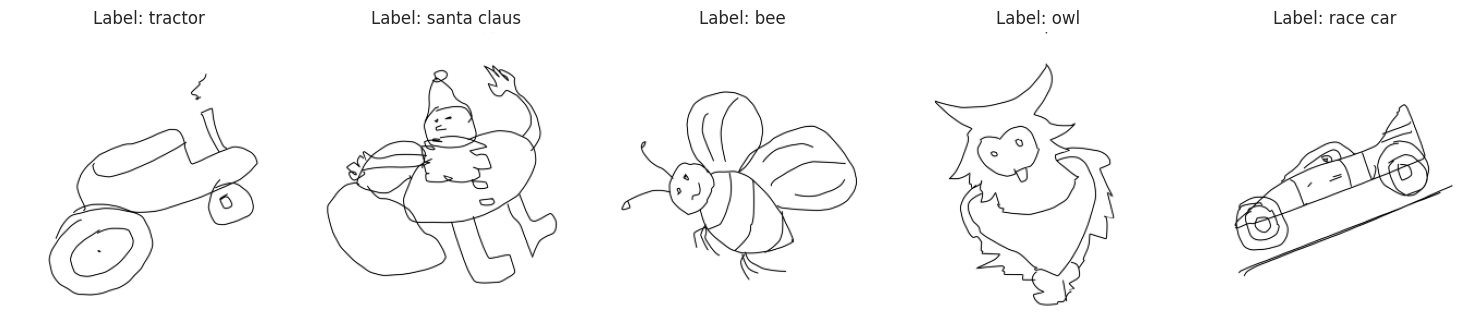

: 

In [ ]:
def show_first_5_images(dataset):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        for i in range(5):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(images[i].numpy())
            # Знаходимо індекс класу з one-hot encoding
            label_index = np.argmax(labels[i].numpy())
            plt.title(f"Label: {class_names[label_index]}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Використання функції
show_first_5_images(train_ds)

In [ ]:
def serialize_example(image, label):
    # Convert the image to uint8 and encode it as JPEG
    image = tf.cast(image * 255, tf.uint8)  # Scale back to [0, 255]
    image = tf.io.encode_jpeg(image)  # Encode as JPEG
    image = image.numpy()  # Convert to bytes

    # Convert the label to an integer (from one-hot encoding)
    label = tf.argmax(label).numpy()

    # Create a TFRecord feature
    feature = {
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

def write_tfrecord(images, labels, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for image, label in zip(images, labels):
            example = serialize_example(image, label)
            writer.write(example)

# Save processed data to TFRecord files
write_tfrecord(train_images_processed, train_labels_processed, "train.tfrecord")
write_tfrecord(val_images_processed, val_labels_processed, "val.tfrecord")

zxc
